# Clustering Results Analysis

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
#import plotly.express as px


from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 

#Import classes
from classes_script import PcaAnalyzer, ClustererPcad, GrapherPcad
from graph_script import run_plots


import plotly.express as px


In [2]:
data = pd.read_csv('./data/final_clustered_extra_cols.csv',index_col=0)

In [3]:
df = data

In [4]:
df.head()

,ID,KM3,GM3,MntTotal,MntSpentNorm,Income,Len_Customer,HasChildren,HasPartner,NumChildren,age,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmpTot,Response,Complain,Year_Birth,Education,Marital_Status,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumTotalPurchases,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response.1,Complain.1,KM2,AC3,AC2,GM2,LogIncome,MntWinesNorm,MntFruitsNorm,MntMeatProductsNorm,MntFishProductsNorm,MntSweetProductsNorm,MntGoldProdsNorm,NumDealsPurchasesNorm,NumWebPurchasesNorm,NumStorePurchasesNorm,NumWebVisitsMonthNorm,NumCatalogPurchasesNorm,SpendPropOfTotal,AvgPerPurchase,NumTotalPurchasesNorm
0,1826,2,0,1190,10.818182,84835.0,110.0,0,0,0,44,0,0,0,0,0,0,1,0,1970,Bachelor,Divorced,0,0,2014-06-16,0,189,104,379,111,189,218,16,1,4,4,6,1,1,0,0,1,0,0,11.348475,1.718182,0.945455,3.445455,1.009091,1.718182,1.981818,0.009091,0.036364,0.054545,0.009091,0.036364,0.101506,74.375000,0.145455
1,1,2,2,577,5.198198,57091.0,111.0,0,0,0,53,0,1,0,0,0,1,1,0,1961,Bachelor,Single,0,0,2014-06-15,0,464,5,64,7,0,37,23,1,7,3,7,5,1,0,0,2,0,0,10.952419,4.180180,0.045045,0.576577,0.063063,0.000000,0.333333,0.009009,0.063063,0.063063,0.045045,0.027027,0.072477,25.086957,0.207207
2,10476,2,2,251,1.743056,67267.0,144.0,1,1,1,56,0,0,0,0,0,0,0,0,1958,Bachelor,Married,0,1,2014-05-13,0,134,11,59,15,2,30,13,1,3,2,5,2,0,0,0,2,0,0,11.116440,0.930556,0.076389,0.409722,0.104167,0.013889,0.208333,0.006944,0.020833,0.034722,0.013889,0.013889,0.020626,19.307692,0.090278
3,1386,1,1,11,0.075342,32474.0,146.0,1,1,2,47,0,0,0,0,0,0,0,0,1967,Bachelor,Together,1,1,2014-05-11,0,10,0,1,0,0,0,11,1,1,0,2,7,0,0,1,0,1,1,10.388226,0.068493,0.000000,0.006849,0.000000,0.000000,0.000000,0.006849,0.006849,0.013699,0.047945,0.000000,0.001847,1.000000,0.075342
4,5371,1,1,91,0.508380,21474.0,179.0,1,0,1,25,0,0,1,0,0,1,1,0,1989,Bachelor,Single,1,0,2014-04-08,0,6,16,24,11,0,34,15,2,3,1,2,7,1,0,1,0,1,1,9.974645,0.033520,0.089385,0.134078,0.061453,0.000000,0.189944,0.011173,0.016760,0.011173,0.039106,0.005587,0.018845,6.066667,0.083799


## KMeans description
- From a high level, our KMeans algorithm follows the below steps in order to find optimal cluster groups:

1. Select k as the number of groups to cluster for
2. Randomly pick k points in our data as centroid points
3. Assign each non-centroid point to its closest centroid
4. Recalculate centroid points by taking the average of all surrounding points assigned to that cluster
5. Repeat steps 3-4 until calculated centroid points do not move anymore. Done
- Source: https://philippeheitzmann.com/2022/01/implementing-kmeans-clustering/

- Based on the elbow method, use 6 clusters. I also tried the silhouette method, which gave ambiguous results.

In [5]:
def plot_counts(data,label):
    # Code hint from https://stackoverflow.com/questions/49044131/how-to-add-data-labels-to-seaborn-countplot-factorplot
    plt.figure(figsize=(9, 7))

    ax = sns.countplot(x=data[label], data=data,hue=None,color='#4503fc',order=data[label].value_counts(ascending=False).index);
            
    abs_values = data[label].value_counts(ascending=False)
    rel_values = data[label].value_counts(ascending=False, normalize=True).values * 100
    lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]
    ax.bar_label(container=ax.containers[0], labels=lbls)
    ax.set_title("Cluster Sizes")



#### Will need this function in the groupby analyses that follow

In [6]:
def total_spent_by_cluster(data,cluster_lab, norm=False):
    norm_lab='Norm' if norm else ""

    n_clusters = data[cluster_lab].nunique()

    cluster_mnt_totals = [[]]*n_clusters

    for i in range(n_clusters):
        cluster_i=data[data[cluster_lab]==i]
        cluster_mnt_totals[i] = cluster_i.MntSpentNorm.mean()*len(cluster_i) if  norm else cluster_i.MntTotal.mean()*len(cluster_i)

    print(cluster_mnt_totals) 

    columns = ['cluster'+str(i) for i in range(n_clusters)]
    print(columns)

    df_cluster_mnt_totals = pd.DataFrame([cluster_mnt_totals], columns = ['cluster'+str(i) for i in range(n_clusters)])

    df_cluster_mnt_totals=df_cluster_mnt_totals.T.reset_index().rename({0:f'TotalAmountSpent{norm_lab}'},axis=1)

    df_cluster_mnt_totals.sort_values(f'TotalAmountSpent{norm_lab}', ascending=False).plot.bar(color='#4503fc')
    #plt.savefig('./figures/total_spent.png')


In [7]:
df.describe()

,ID,KM3,GM3,MntTotal,MntSpentNorm,Income,Len_Customer,HasChildren,HasPartner,NumChildren,age,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmpTot,Response,Complain,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumTotalPurchases,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response.1,Complain.1,KM2,AC3,AC2,GM2,LogIncome,MntWinesNorm,MntFruitsNorm,MntMeatProductsNorm,MntFishProductsNorm,MntSweetProductsNorm,MntGoldProdsNorm,NumDealsPurchasesNorm,NumWebPurchasesNorm,NumStorePurchasesNorm,NumWebVisitsMonthNorm,NumCatalogPurchasesNorm,SpendPropOfTotal,AvgPerPurchase,NumTotalPurchasesNorm
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.00000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,5589.296097,0.916106,1.228802,605.541050,1.652585,51619.504262,450.777479,0.716016,0.644235,0.951996,45.111261,0.064603,0.013459,0.073127,0.074921,0.072678,0.298789,0.149843,0.008973,1968.888739,0.444594,0.507402,49.106326,304.991476,26.348587,165.283984,37.642441,27.161507,44.113055,20.20323,2.319874,4.100045,2.636608,5.812472,5.334231,0.149843,0.008973,0.470166,0.656797,0.533423,0.459399,10.749553,0.818573,0.074516,0.460445,0.106404,0.075355,0.117292,0.006314,0.011353,0.016613,0.014840,0.007382,0.020761,26.840943,0.056501
std,3244.840538,0.769513,0.763070,601.032228,2.171865,20601.216248,202.248700,0.451030,0.478852,0.751976,11.707430,0.245879,0.115255,0.260403,0.263324,0.259666,0.679597,0.356998,0.094319,11.707430,0.538636,0.544735,28.946476,336.761943,39.764060,219.336589,54.700548,41.338945,52.091255,7.23009,1.895252,2.775461,2.796161,3.242144,2.414981,0.356998,0.094319,0.499221,0.778541,0.498994,0.498461,0.496424,1.119062,0.146868,0.771058,0.205539,0.145509,0.188556,0.006981,0.011189,0.014303,0.012084,0.010395,0.028764,43.424736,0.038231
min,0.000000,0.000000,0.000000,5.000000,0.009276,1730.000000,97.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1940.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.456455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000393,0.228571,0.001277
25%,2829.000000,0.000000,1.000000,69.000000,0.202899,35416.000000,278.000000,0.000000,0.000000,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1959.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,14.00000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.474947,0.067873,0.003565,0.042857,0.006319,0.003623,0.022487,0.002571,0.004808,0.007194,0.008152,0.000000,0.005331,5.000000,0.032000
50%,5455.000000,1.000000,1.000000,397.000000,0.867257,51381.500000,453.000000,1.000000,1.000000,1.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1970.000000,0.000000,0.000000,49.000000,176.000000,8.000000,67.000000,12.000000,8.000000,24.000000,19.00000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10.847053,0.418900,0.019920,0.152455,0.028777,0.020000,0.057441,0.004622,0.008671,0.012658

## Groupby and Total Spent Analyses

### KMeans with 3 Clusters

In [8]:
LABEL='KM3'

In [9]:
groupsByCluster=df.groupby([LABEL])#.agg(['count', 'sum', 'min', 'max', 'mean', 'std'])
groupsByCluster.agg(['count', 'sum', 'min', 'max', 'mean', 'std'])

ID                                                 GM3                \
    count      sum min    max         mean          std count   sum min max   
KM3                                                                           
0     761  4201083  17  11176  5520.477004  3312.530743   761  1518   0   2   
1     894  5025113   9  11191  5620.931767  3231.023557   894   973   1   2   
2     574  3232345   0  11101  5631.263066  3179.126213   574   248   0   2   

                        MntTotal                                              \
         mean       std    count     sum  min   max         mean         std   
KM3                                                                            
0    1.994744  0.102463      761  520480  138  2053   683.942181  393.578818   
1    1.088367  0.283987      894   64835    5  1730    72.522371   77.671495   
2    0.432056  0.823785      574  764436  222  2525  1331.770035  458.246147   

    MntSpentNorm                                                       Income  \
           count          sum       min        max      mean       std  count   
KM3                                                                             
0            761  1146.287662  0.200528   8.071429  1.506291  1.077276    761   
1            894   195.697553  0.009276   2.720126  0.218901  0.215126    894   
2            574  2341.626654  0.477733  19.788991  4.079489  2.755766    574   

                                                               Len_Customer  \
            sum      min       max          mean           std        count   
KM3                                                                           
0    42360494.0   7144.0   94871.0  55664.249671  11800.593563          761   
1    29298520.0   1730.0   64587.0  32772.393736  11723.283202          894   
2    43400861.0  38620.0  113734.0  75611.256098   9940.068280          574   

                                                   HasChildren               \
          sum   min    max        mean         std       count  sum min max   
KM3                                                                           
0    395758.0  97.0  796.0  520.049934  188.745443         761  710   0   1   
1    367652.0  97.0  794.0  411.243848  197.881413         894  788   0   1   
2    241373.0  98.0  795.0  420.510453  202.593617         574   98   0   1   

                        HasPartner                                   \
         mean       std      count  sum min max      mean       std   
KM3                                                                   
0    0.932983  0.250216        761  499   0   1  0.655716  0.475447   
1    0.881432  0.323461        894  577   0   1  0.645414  0.478655   
2    0.170732  0.376603        574  360   0   1  0.627178  0.483977   

    NumChildren                                     age                 \
          count   sum min max      mean       std count    sum min max   
KM3                                                                      
0           761   918   0   3  1.206307  0.592286   761  36606  22  71   
1           894  1105   0   3  1.236018  0.701303   894  37521  18  74   
2           574    99   0   2  0.172474  0.382709   574  26426  19  73   

                          AcceptedCmp1                                   \
          mean        std        count  sum min max      mean       std   
KM3                                                                       
0    48.102497  10.250161          761   26   0   1  0.034166  0.181774   
1    41.969799  10.820027          894    1   0   1  0.001119  0.033445   
2    46.038328  13.527630          574  117   0   1  0.203833  0.403197   

    AcceptedCmp2                                 AcceptedCmp3              \
           count sum min max      mean       std        count sum min max   
KM3                                                                         
0            761   9   0   1  0.011827  0.108176          76

- KM3 results
- Cluster 2 spends most, has highest income, way fewer kids (but most likely to have a partner)
- make fewer purchases than Cluster 0, but double spending per person
- Campaigns 1 and 5 were most successful with them
- 46 yrs old on average, compared to 48 for Cluster 0  and 42 for Cluster 2

- Figure out how much each cluster spends

[520480.0, 64834.99999999999, 764436.0]
['cluster0', 'cluster1', 'cluster2']


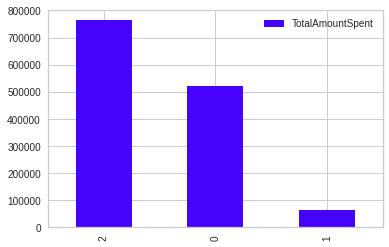

In [10]:
total_spent_by_cluster(data=df,cluster_lab=LABEL)

[1146.2876623353693, 195.6975528534914, 2341.6266540907473]
['cluster0', 'cluster1', 'cluster2']


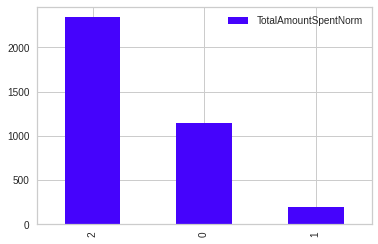

In [11]:
total_spent_by_cluster(data=df,cluster_lab=LABEL,norm=True)

<AxesSubplot:title={'center':'Number of Customers by Cluster'}>

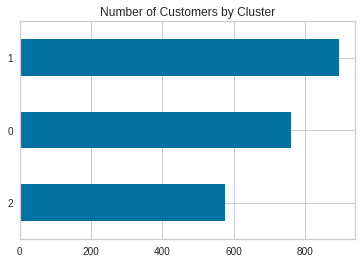

In [12]:
df[LABEL].value_counts().sort_values().plot(kind = 'barh',title="Number of Customers by Cluster")

<!-- # Description of Customer Behavior
- Clusters 2 and 4 are big clusters that spend little
- Clusters 2 and 4  are usually educated, relatively recent customers, but are much more likely to have children than Clusters 1 and 3. Perhaps this store focuses on high-end more expensive products (Whole Foods at Monterey?) and people with children are finding it harder to afford shopping there, on average.  Cluster 5 customers have about just as likely to have children as Clusters 2 and 4, yet have a higher income.  
- To confirm these findings, Clusters 2, 4, and 5 are making the most deal purchases, especially when these are normalized by length someone spend as a customer.
 -->

### GMM with 3 Clusters

In [13]:
LABEL='GM3'

In [14]:
groupsByCluster=df.groupby([LABEL])#.agg(['count', 'sum', 'min', 'max', 'mean', 'std'])
#groupsByCluster.agg(['count', 'sum', 'min', 'max', 'mean', 'std'])
groupsByCluster.agg(['sum','mean', 'min', 'max', 'std'])

ID                                       KM3                    \
         sum         mean min    max          std  sum      mean min max   
GM3                                                                        
0    2559469  5662.542035   0  11101  3205.219261  900  1.991150   0   2   
1    4643574  5697.636810  13  11191  3217.877052  815  1.000000   1   1   
2    5255498  5463.095634   1  11176  3284.816367  327  0.339917   0   2   

              MntTotal                                     MntSpentNorm  \
          std      sum         mean  min   max         std          sum   
GM3                                                                       
0    0.132890   639552  1414.938053  461  2525  413.828559  1929.939958   
1    0.000000    49831    61.142331    5   373   40.677063   151.021093   
2    0.694746   660368   686.453222    9  2194  435.548787  1602.650818   

                                                  Income                \
         mean       min        max       std         sum          mean   
GM3                                                                      
0    4.269779  0.819749  19.788991  2.881446  34827702.5  77052.439159   
1    0.185302  0.009276   1.260135  0.149402  25815384.0  31675.317791   
2    1.665957  0.087379  12.669065  1.404579  54416788.5  56566.308212   

                                     Len_Customer                           \
         min       max           std          sum        mean   min    max   
GM3                                                                          
0    44953.0  105471.0   9280.880031     197258.0  436.411504  98.0  795.0   
1     1730.0   61917.0  10996.097129     335504.0  411.661350  97.0  794.0   
2     2447.0  113734.0  13230.597083     472021.0  490.666320  97.0  796.0   

                HasChildren                             HasPartner            \
            std         sum      mean min max       std        sum      mean   
GM3                                                                            
0    204.814131           9  0.019912   0   1  0.139851        268  0.592920   
1    197.084420         731  0.896933   0   1  0.304234        528  0.647853   
2    198.138659         856  0.889813   0   1  0.313286        640  0.665281   

                      NumChildren                                age  \
    min max       std         sum      mean min max       std    sum   
GM3                                                                    
0     0   1  0.491834           9  0.019912   0   1  0.139851  20643   
1     0   1  0.477933        1033  1.267485   0   3  0.695447  33581   
2     0   1  0.472138        1080  1.122661   0   3  0.608239  46329   

                                  AcceptedCmp1                              \
          mean min max        std          sum      mean min max       std   
GM3                                                                          
0    45.670354  19  73  14.171259          106  0.234513   0   1  0.424164   
1    41.203681  18  68  10.466173            0  0.000000   0   0  0.000000   
2    48.159044  22  74  10.408847           38  0.039501   0   1  0.194885   

    AcceptedCmp2                             AcceptedCmp3                    \
             sum      mean min max       std          sum      mean min max   
GM3                                                                           
0             12  0.026549   0   1  0.160938           36  0.079646   0   1   
1              2  0.002454   0   1  0.049507           58  0.071166   0   1   
2             16  0.016632   0   1  0.127955           69  0.071726   0   1   

              AcceptedCmp4                             AcceptedCmp5            \
          std          sum      mean min max       std          sum      mean   
GM3                                                                             
0    0.271044           55  0.121681   0   1  0.327280          128  0.283186   
1    0

- GM3 results:
- Cluster 2 spends most, has highest income, way fewer kids (but most likely to have a partner)
- make fewer purchases than Cluster 0, but double spending per person
- Campaigns 1 and 5 were most successful with them
- 46 yrs old on average, compared to 48 for Cluster 0  and 42 for Cluster 2

- Figure out how much each cluster spends

[639552.0, 49831.0, 660368.0]
['cluster0', 'cluster1', 'cluster2']


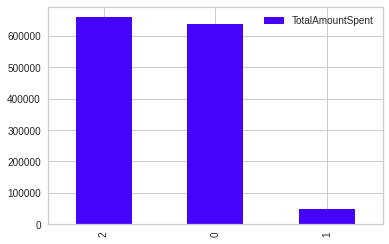

In [15]:
total_spent_by_cluster(data=df,cluster_lab=LABEL)

[1929.9399581581583, 151.02109276323716, 1602.650818358213]
['cluster0', 'cluster1', 'cluster2']


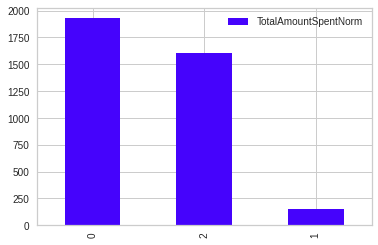

In [16]:
total_spent_by_cluster(data=df,cluster_lab=LABEL,norm=True)

<AxesSubplot:title={'center':'Number of Customers by Cluster'}>

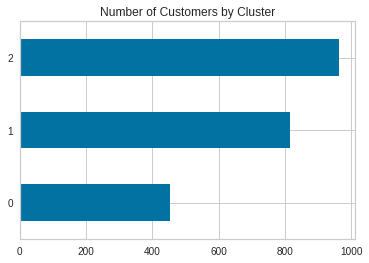

In [17]:
df[LABEL].value_counts().sort_values().plot(kind = 'barh',title="Number of Customers by Cluster")

<!-- # Description of Customer Behavior
- Clusters 2 and 4 are big clusters that spend little
- Clusters 2 and 4  are usually educated, relatively recent customers, but are much more likely to have children than Clusters 1 and 3. Perhaps this store focuses on high-end more expensive products (Whole Foods at Monterey?) and people with children are finding it harder to afford shopping there, on average.  Cluster 5 customers have about just as likely to have children as Clusters 2 and 4, yet have a higher income.  
- To confirm these findings, Clusters 2, 4, and 5 are making the most deal purchases, especially when these are normalized by length someone spend as a customer.
 -->

### Graphs for Clusters

##### Add additional variables to see if length as customer reverses results of some category spending

--------------------Producing plots for KM3--------------------
CLUSTERING RESULTS OVER AMOUNT SPENT AND LENGTH AS CUSTOMER
Income vs Total Amount Plot


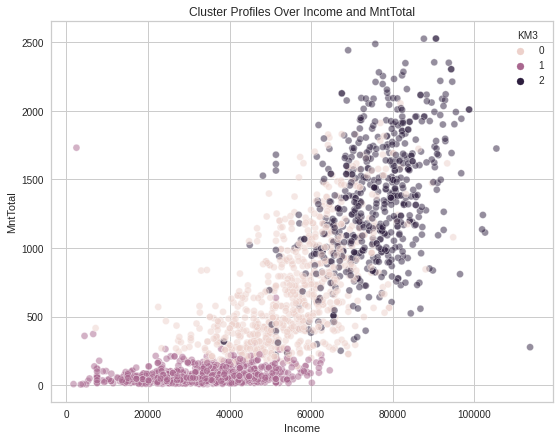

Income vs Total Normalized Amount Plot


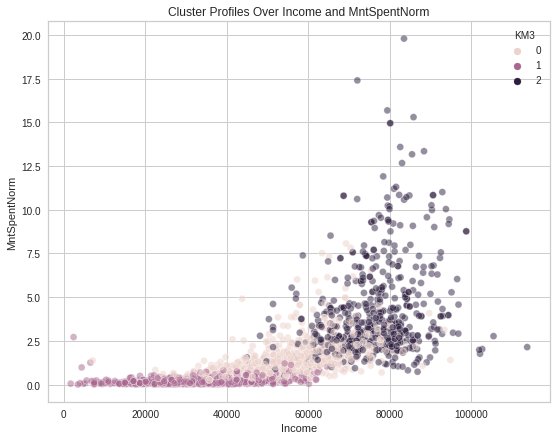

CLUSTERINS OVER DEMOGRAPHIC VARIABLES
EXAMINE DEALS AND CAMPAIGNS
CLUSTERS OVER CAMPAIGNS
CLUSTERS OVER PURCHASE MEDIUM
CLUSTERS OVER PRODUCT TYPE
CLUSTERS OVER RECENCY


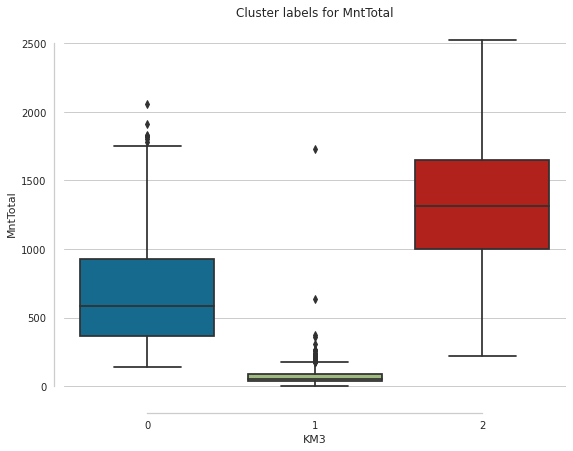

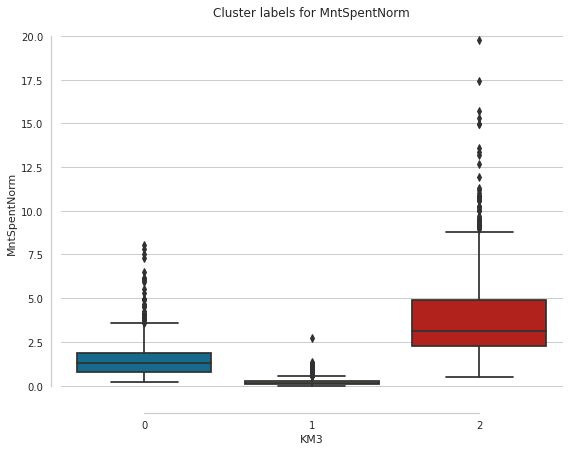

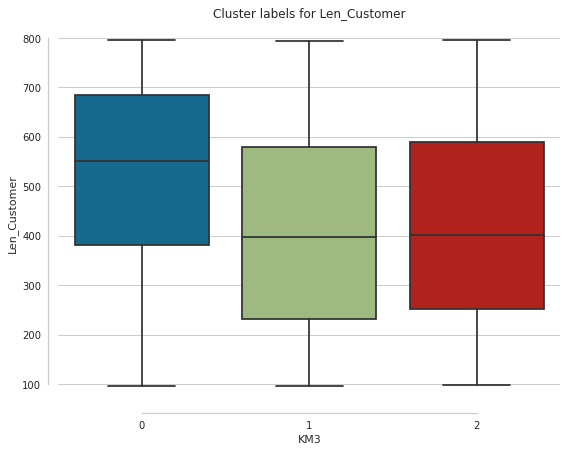

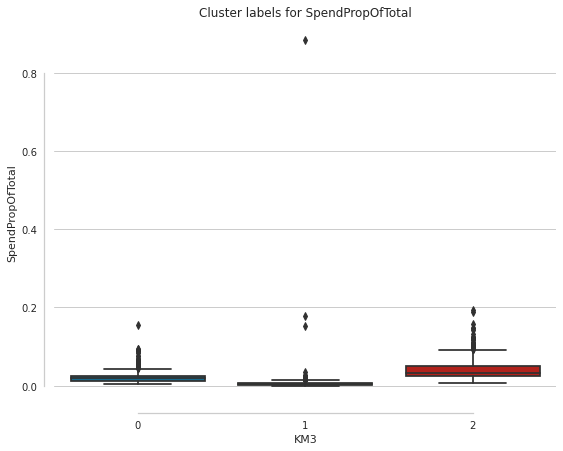

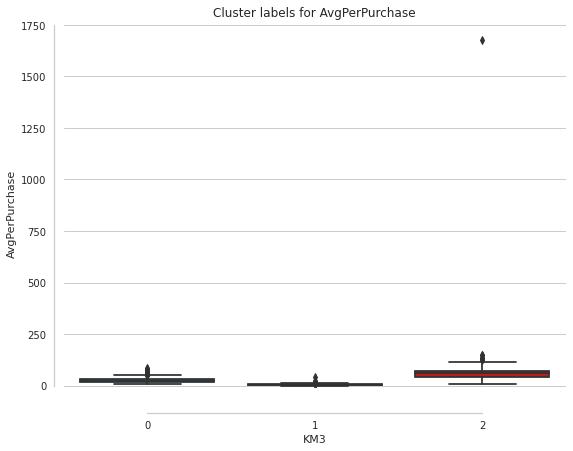

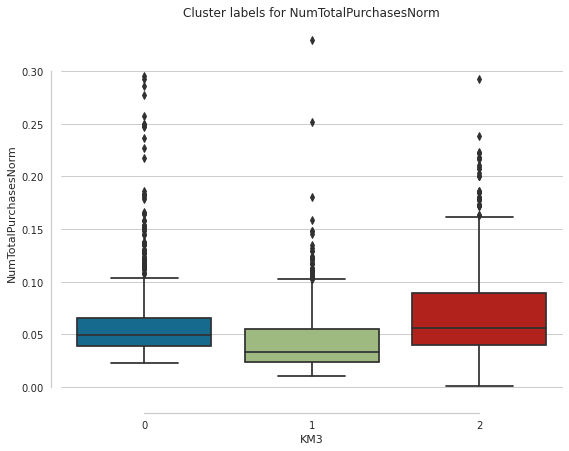

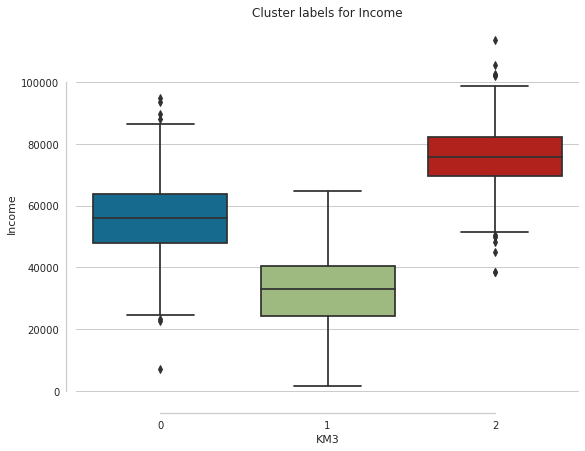

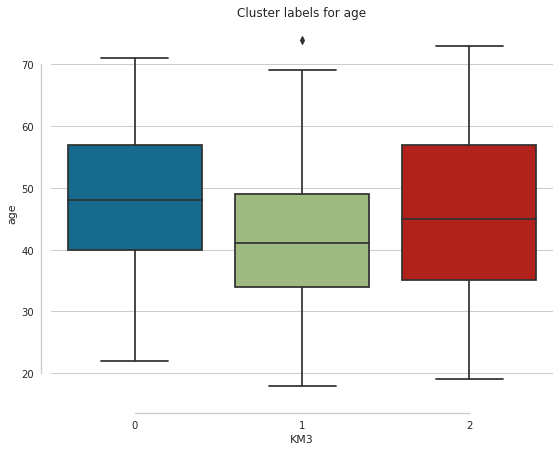

posx and posy should be finite values
posx and posy should be finite values


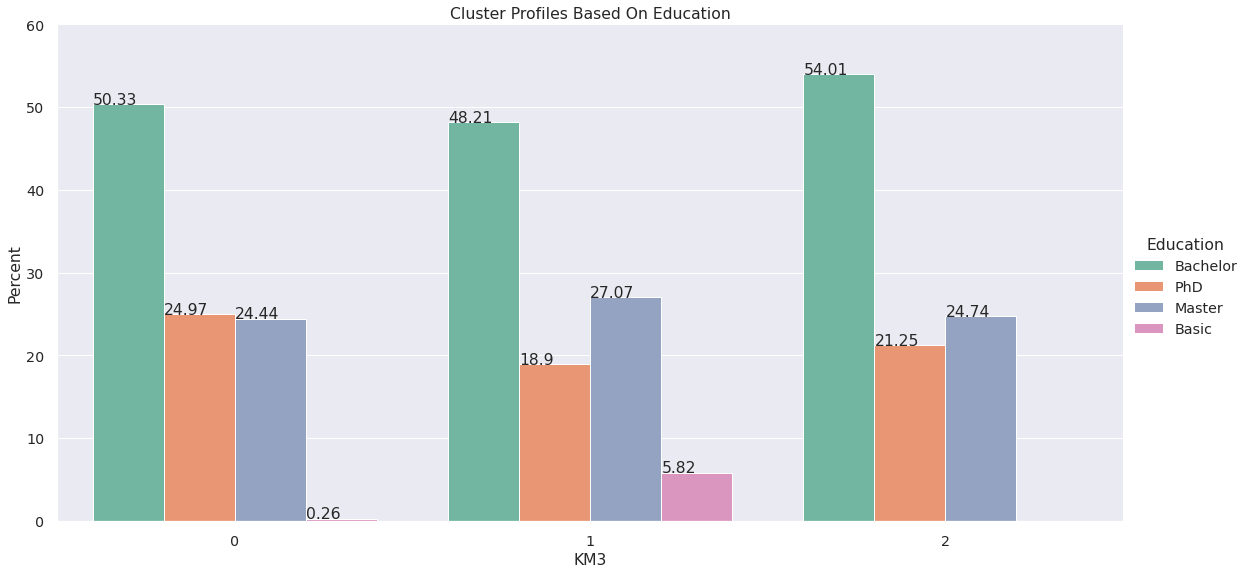

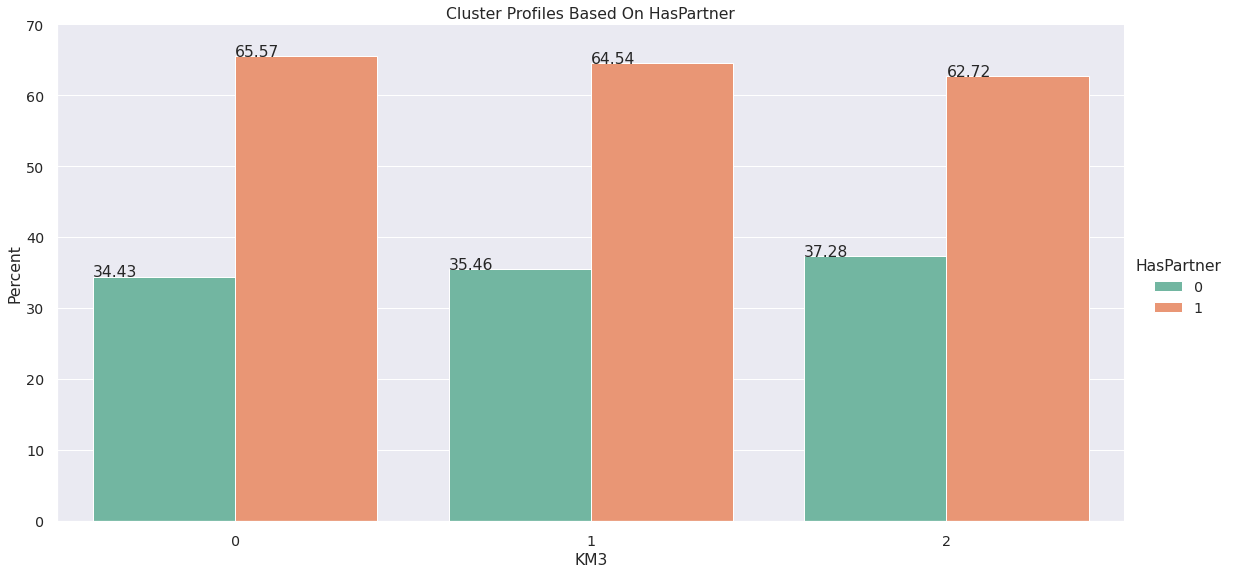

posx and posy should be finite values
posx and posy should be finite values


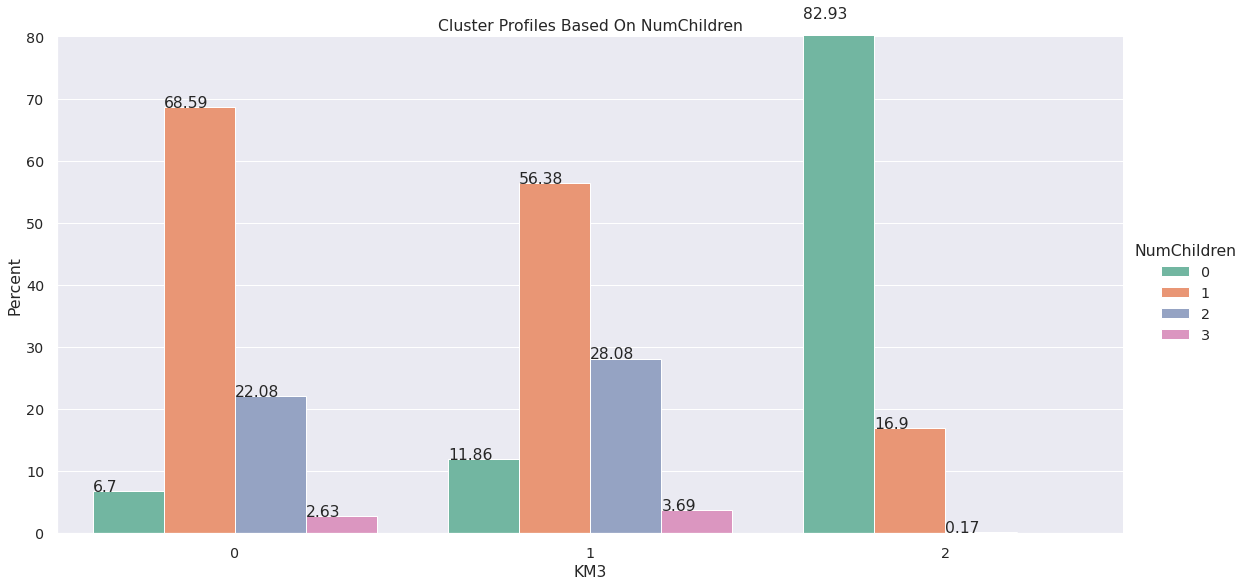

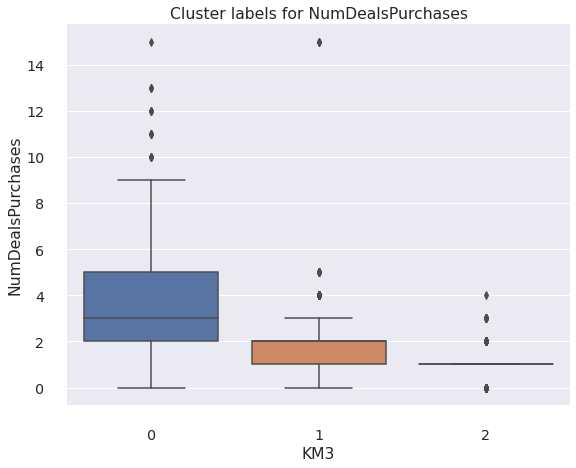

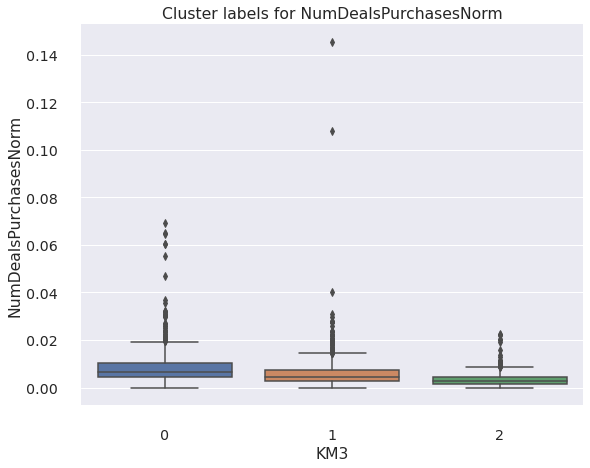

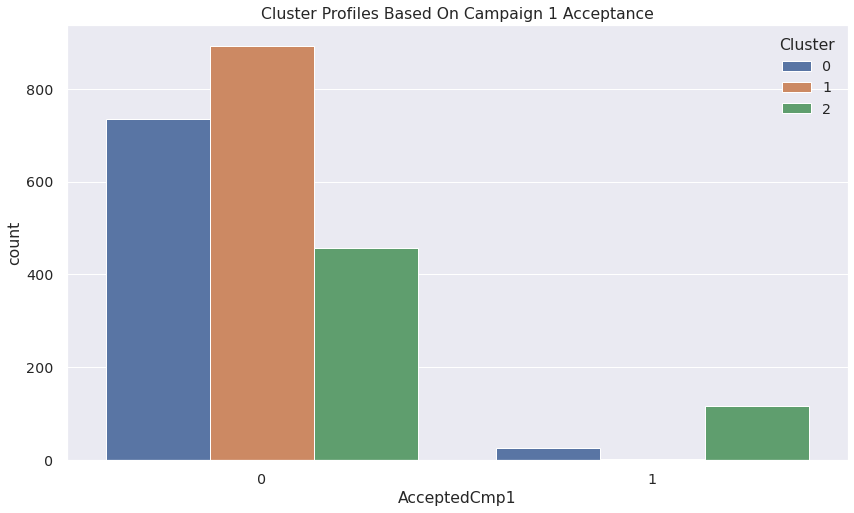

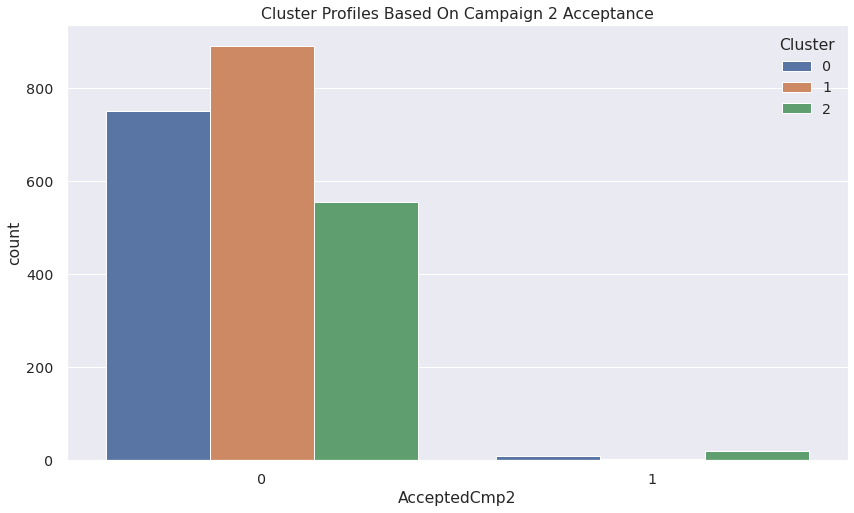

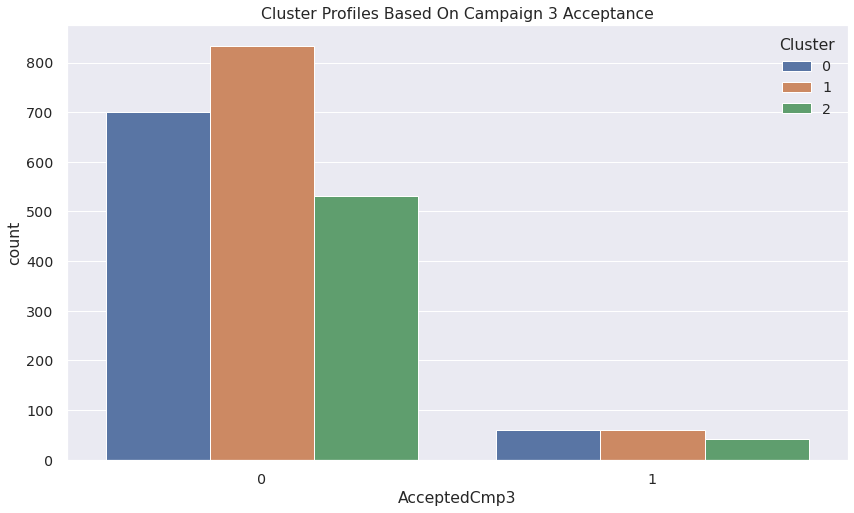

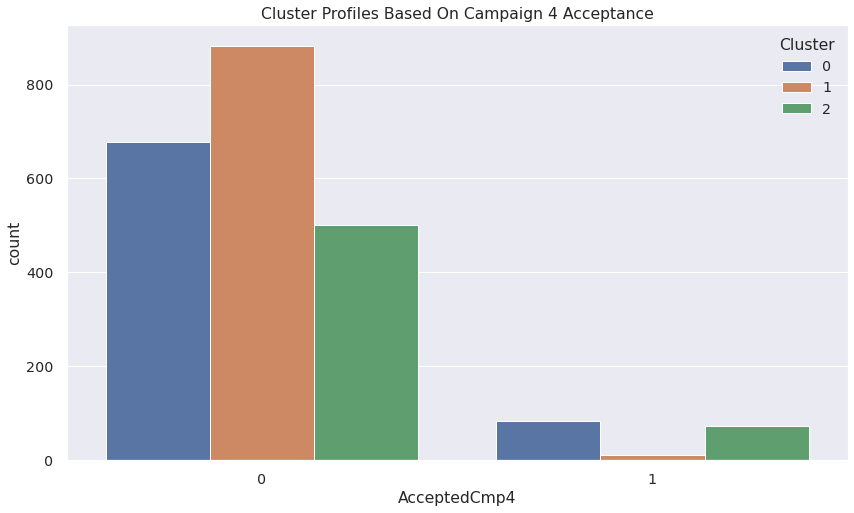

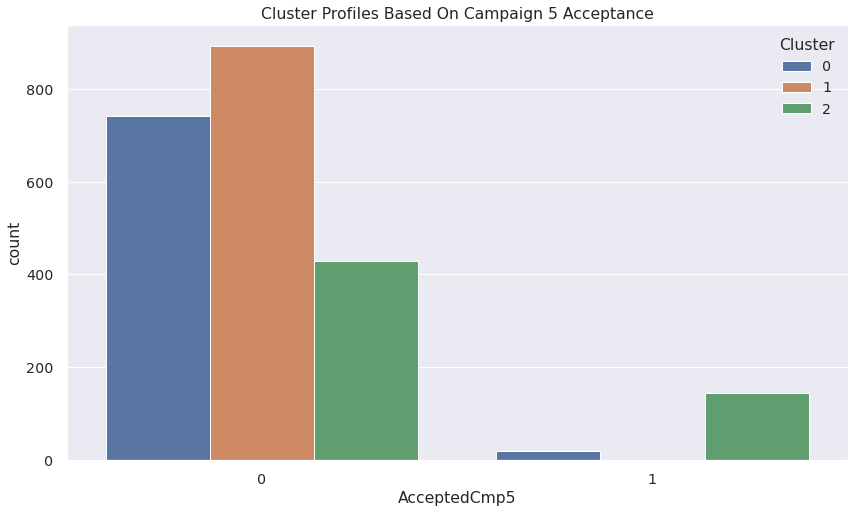

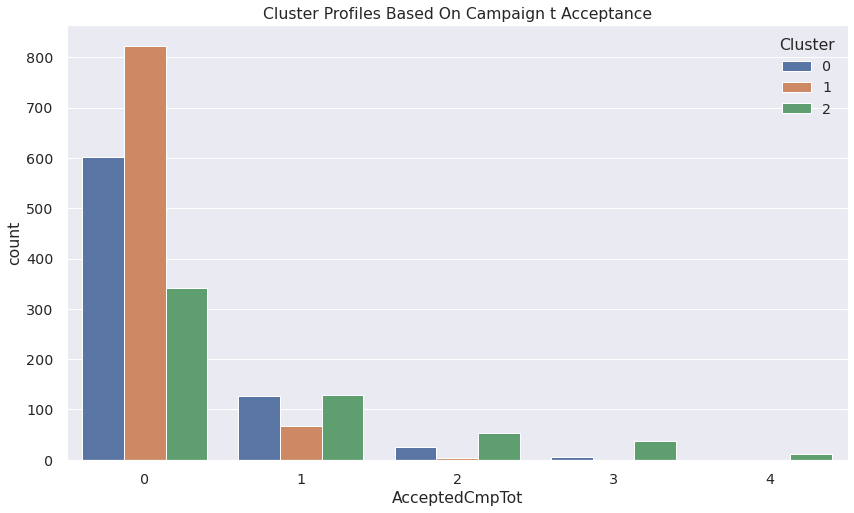

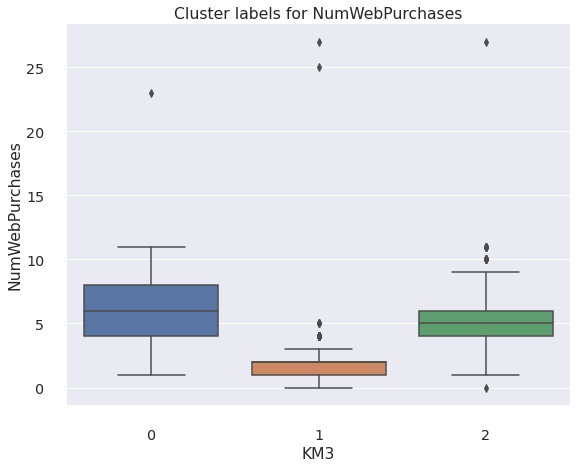

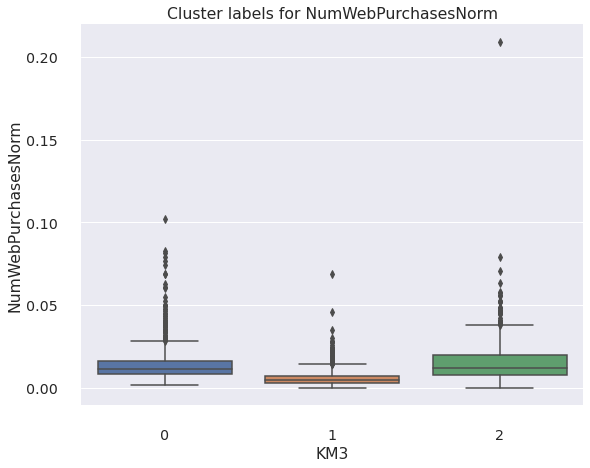

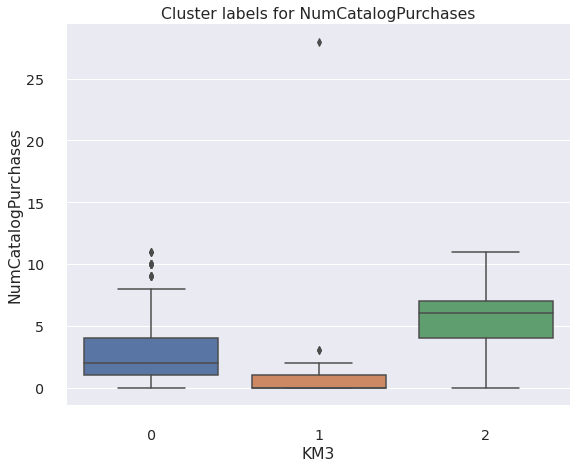

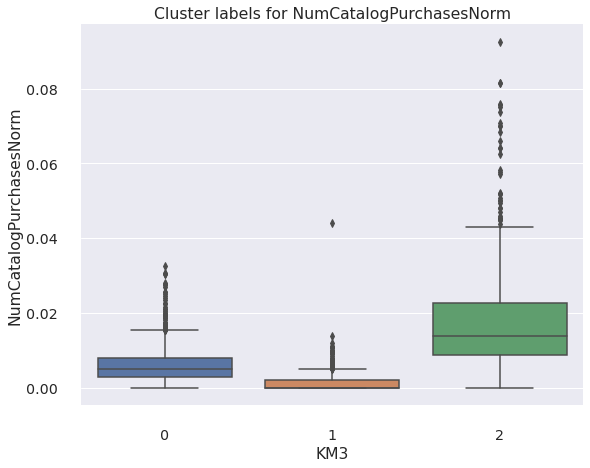

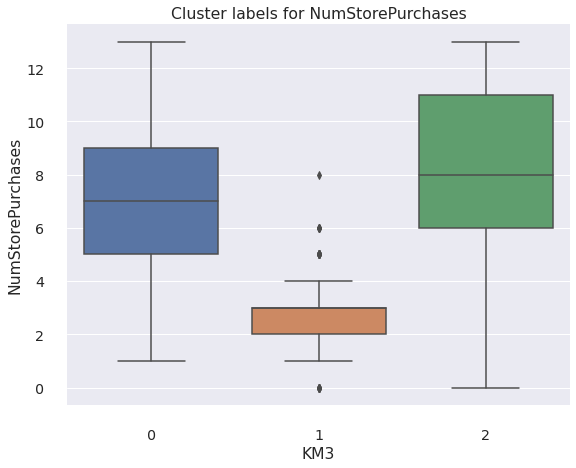

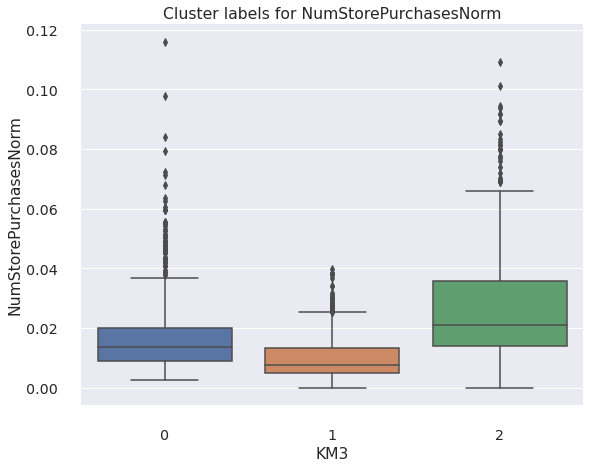

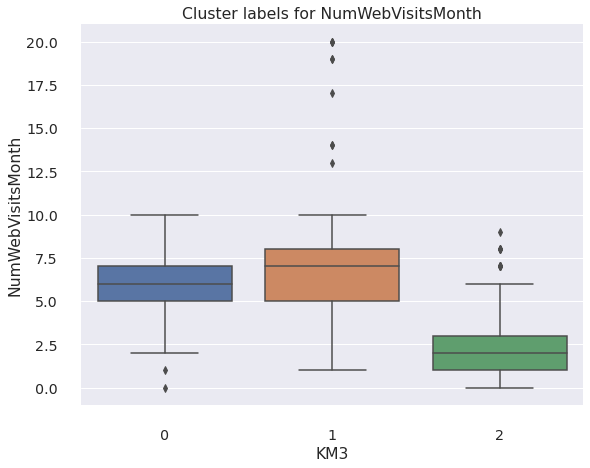

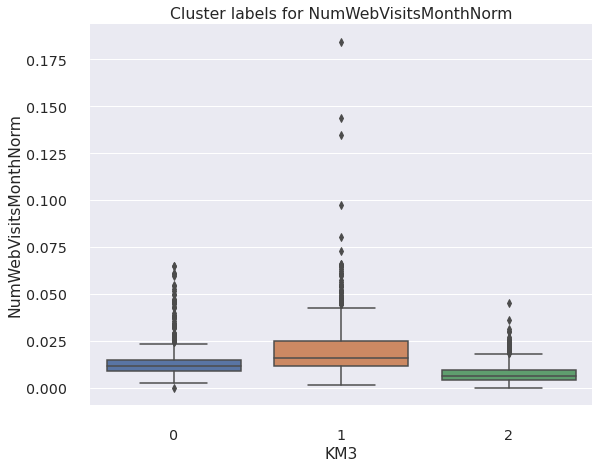

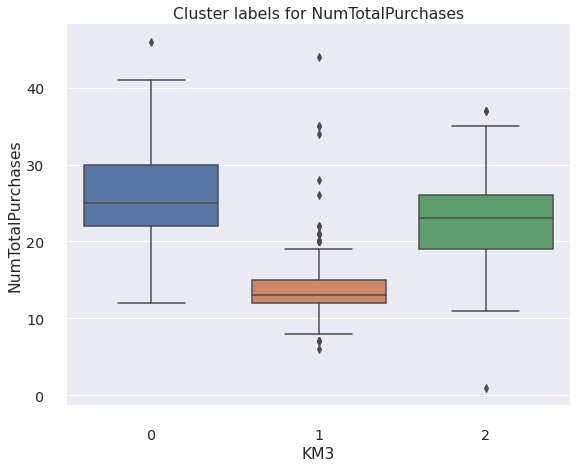

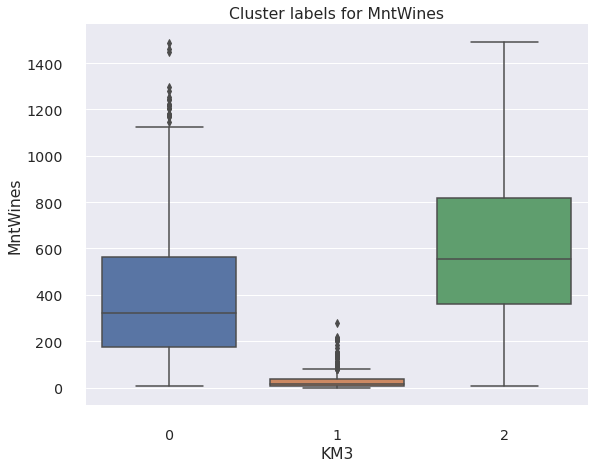

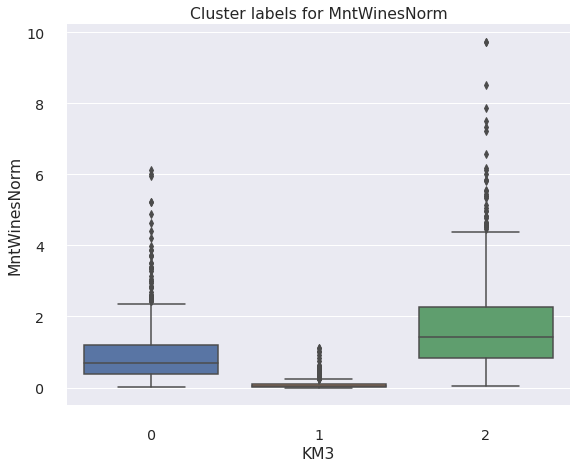

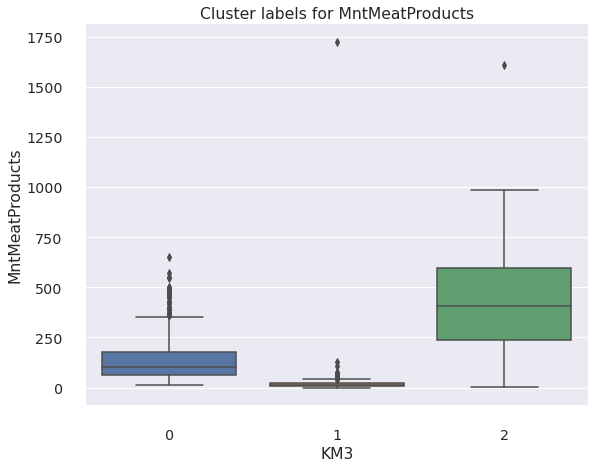

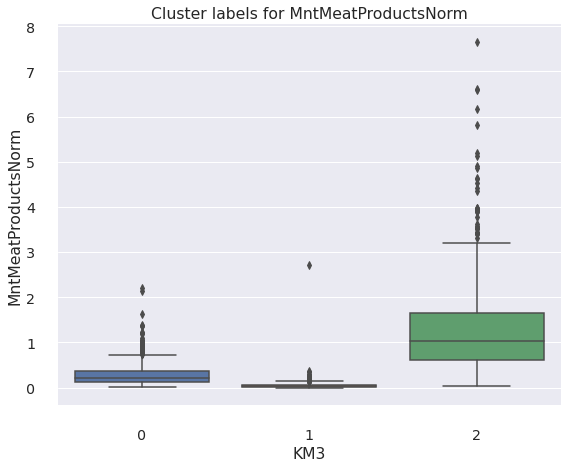

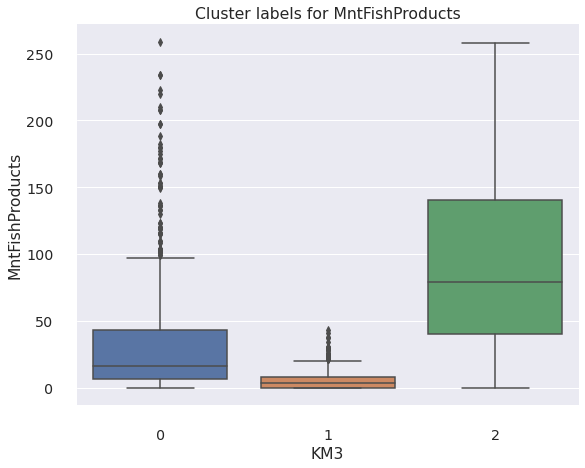

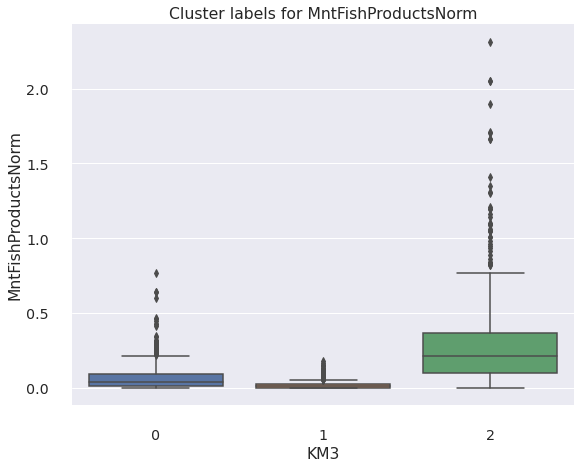

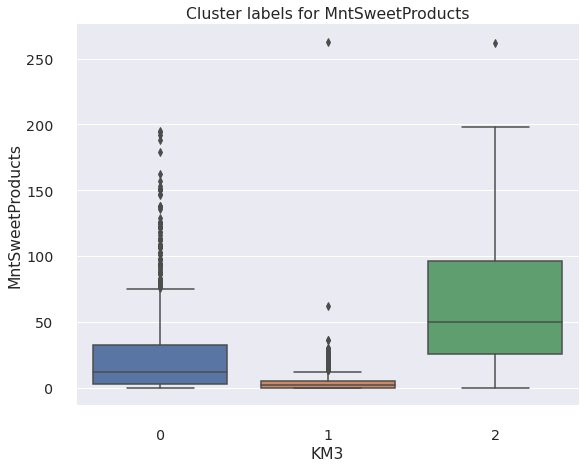

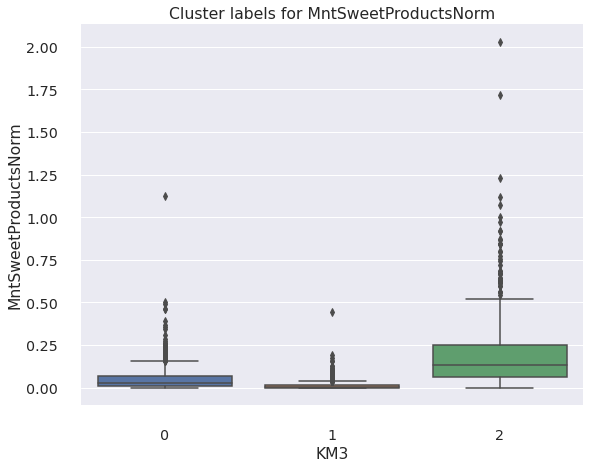

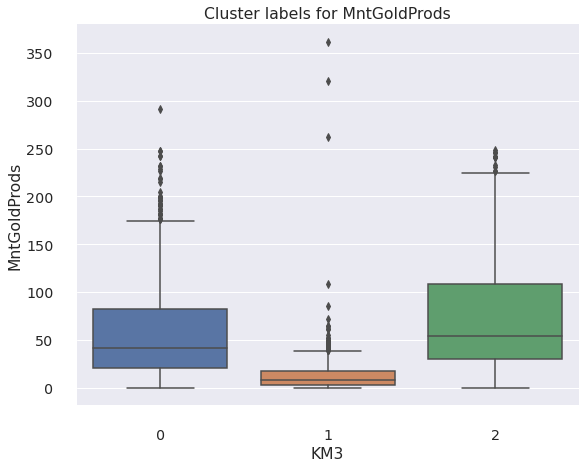

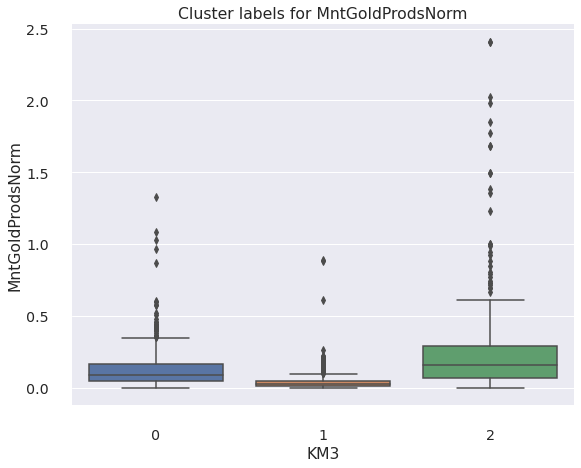

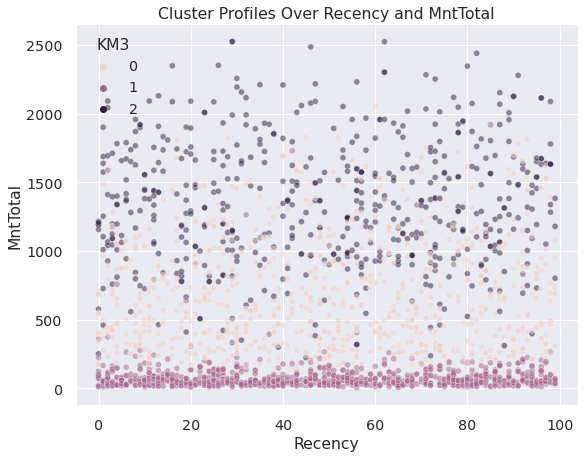

In [18]:
run_plots(data=df)

## Additional analyses

#### KMeans2 results

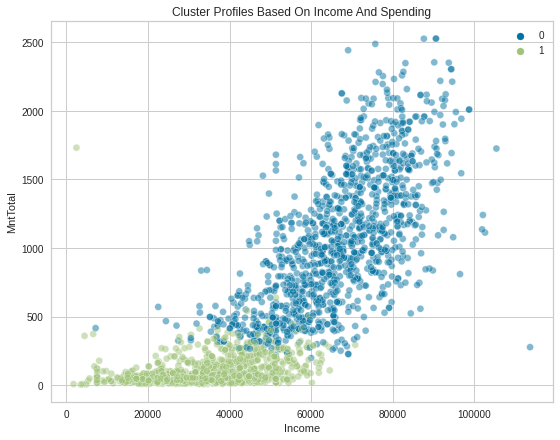

In [ ]:
cluster_scatter(data=df,x_lab='Income',y_lab='MntTotal',cluster_lab='KM2')

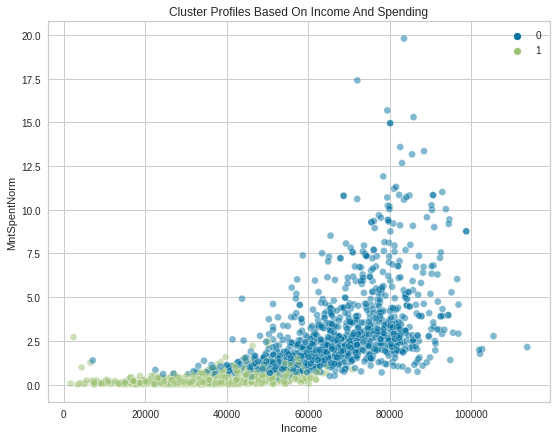

In [ ]:
cluster_scatter(data=df,x_lab='Income',y_lab='MntSpentNorm',cluster_lab='KM2')

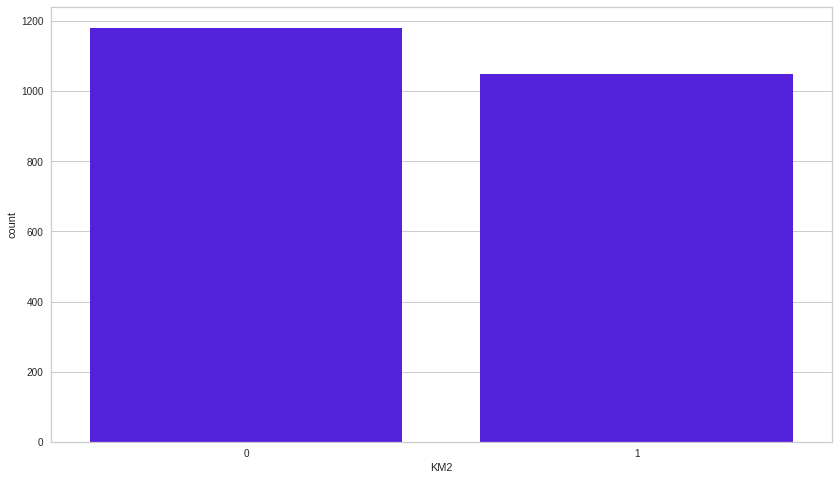

In [ ]:
plt.figure(figsize=(14, 8))
sns.countplot(x='KM2', data=df,hue=None,color='#4503fc',)
plt.show()

In [ ]:
df.KM2.value_counts()

0    1181
1    1048
Name: KM2, dtype: int64

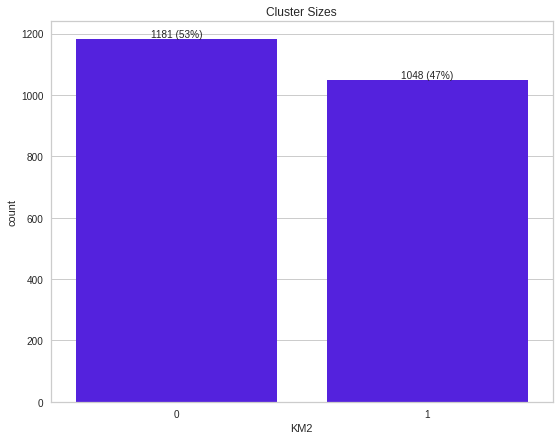

In [51]:
plot_counts(df,'KM2')

### Agglomerative Clustering with 3 Clusters

In [ ]:
LABEL='AC3'

In [ ]:
groupsByCluster=df.groupby([LABEL])#.agg(['count', 'sum', 'min', 'max', 'mean', 'std'])
groupsByCluster.agg(['count', 'sum', 'min', 'max', 'mean', 'std'])

ID                                                 KM3                \
    count      sum min    max         mean          std count   sum min max   
AC3                                                                           
0    1189  6662851   9  11188  5603.743482  3261.684892  1189   881   0   2   
1     616  3434199   0  11191  5574.998377  3232.507751   616  1063   0   2   
2     424  2361491   1  11176  5569.554245  3222.705820   424    98   0   2   

                          GM3                                   MntTotal  \
         mean       std count   sum min max      mean       std    count   
AC3                                                                        
0    0.740959  0.440209  1189  1569   1   2  1.319596  0.466516     1189   
1    1.725649  0.670681   616   334   0   2  0.542208  0.884282      616   
2    0.231132  0.640163   424   836   0   2  1.971698  0.236505      424   

                                                MntSpentNorm               \
        sum  min   max         mean         std        count          sum   
AC3                                                                         
0    187693    5  1730   157.857864  195.602124         1189   470.594372   
1    791741   71  2525  1285.293831  486.368036          616  2280.338370   
2    370317  174  2092   873.389151  378.370754          424   932.679127   

                                             Income                       \
          min        max      mean       std  count         sum      min   
AC3                                                                        
0    0.009276   3.378571  0.395790  0.449898   1189  44025197.5   1730.0   
1    0.182990  19.788991  3.701848  2.793991    616  45108702.5   4428.0   
2    0.414921   8.149254  2.199715  1.439241    424  25925975.0  27421.0   

                                          Len_Customer                         \
          max          mean           std        count       sum   min    max   
AC3                                                                             
0     76068.0  37027.079479  13474.951019         1189  517570.0  97.0  796.0   
1    113734.0  73228.413149  12792.847565          616  279551.0  98.0  795.0   
2     93404.0  61146.167453  10863.753066          424  207662.0  97.0  793.0   

                            HasChildren                                    \
           mean         std       count   sum min max      mean       std   
AC3                                                                         
0    435.298570  197.088409        1189  1082   0   1  0.910008  0.286290   
1    453.816558  203.666379         616   121   0   1  0.196429  0.397619   
2    489.768868  209.375066         424   393   0   1  0.926887  0.260630   

    HasPartner                                  NumChildren                \
         count  sum min max      mean       std       count   sum min max   
AC3                                                                         
0         1189  774   0   1  0.650967  0.476865        1189  1501   0   3   
1          616  376   0   1  0.610390  0.488058         616   124   0   2   
2          424  286   0   1  0.674528  0.469104         424   497   0   3   

                          age                                       \
         mean       std count    sum min max       mean        std   
AC3                                                                  
0    1.262405  0.668010  1189  51764  18  74  43.535744  10.907621   
1    0.201299  0.413274   616  27723  19  73  45.004870  13.506216   
2    1.172170  0.580274   424  21066  24  70  49.683962   9.727207   

    AcceptedCmp1                                  AcceptedCmp2              \
           count  sum min max      mean       std        count sum min max   
AC3                                                                          
0           1189    6   0   1  0.005046  0.070887         1189   6   0   1   
1        

- The initial cluster visualizations in the previous notebook showed that clusters were less separated.  The results of groupby also seem less clear cut. Decide to pursue KMeans and Gaussian Mixture Models only.

[187693.0, 791741.0000000001, 370317.0]
['cluster0', 'cluster1', 'cluster2']


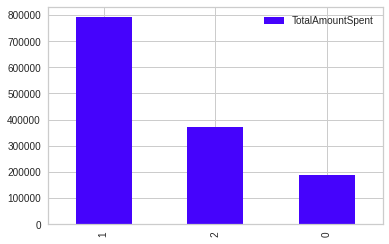

In [ ]:
total_spent_by_cluster(data=df,cluster_lab=LABEL)

[470.59437185543754, 2280.338370004106, 932.6791274200651]
['cluster0', 'cluster1', 'cluster2']


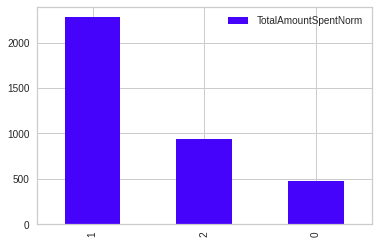

In [ ]:
total_spent_by_cluster(data=df,cluster_lab=LABEL,norm=True)

<!-- # Description of Customer Behavior
- Clusters 2 and 4 are big clusters that spend little
- Clusters 2 and 4  are usually educated, relatively recent customers, but are much more likely to have children than Clusters 1 and 3. Perhaps this store focuses on high-end more expensive products (Whole Foods at Monterey?) and people with children are finding it harder to afford shopping there, on average.  Cluster 5 customers have about just as likely to have children as Clusters 2 and 4, yet have a higher income.  
- To confirm these findings, Clusters 2, 4, and 5 are making the most deal purchases, especially when these are normalized by length someone spend as a customer.
 -->